# Correlación entre contaminantes

In [1]:
# Autoguardado cada 10 segundos
%autosave 10

Autosaving every 10 seconds


In [2]:
#Bibliotecas necesarias en python para implementar el análisis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [3]:
# Obtenemos los datasets de contaminantes de 2018
data_19 = pd.read_csv("contaminantes_2019.CSV", header = 10)

In [35]:
data_19.id_parameter.unique()

array(['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'PM2.5', 'PMCO'],
      dtype=object)

In [4]:
# Exploramos el data set
data_19.head()

,date,id_station,id_parameter,value,unit
0,01/01/2019 01:00,ACO,CO,NaN,15
1,01/01/2019 01:00,ACO,NO,NaN,1
2,01/01/2019 01:00,ACO,NO2,NaN,1
3,01/01/2019 01:00,ACO,NOX,NaN,1
4,01/01/2019 01:00,ACO,O3,NaN,1


In [5]:
# Encontramos los nombres de cada estación de monitoreo y las guardamos en una lista
estaciones_19 = data_19.id_station.unique()

estacion_= {nombre: pd.DataFrame for nombre in estaciones_19}

for key in estacion_.keys():
    estacion_[key] = data_19[:][data_19.id_station == key]


In [6]:
# Estacion ACO
estacion_ACO = estacion_['ACO']
estacion_ACO = estacion_ACO.reset_index(drop = True)
estacion_ACO.head()

,date,id_station,id_parameter,value,unit
0,01/01/2019 01:00,ACO,CO,NaN,15
1,01/01/2019 01:00,ACO,NO,NaN,1
2,01/01/2019 01:00,ACO,NO2,NaN,1
3,01/01/2019 01:00,ACO,NOX,NaN,1
4,01/01/2019 01:00,ACO,O3,NaN,1


In [34]:
estacion_ACO.id_parameter.unique()

array(['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2'], dtype=object)

In [7]:
# Esta función establece las 24 hrs originales del dataset como las 00:00:00, esto es necesario para poder trabajar
# esos campos como tipo 'datetime'. De la misma manera separa la hora del tiempo
def time_parser(df):
    df["hour"] = df['date'].str[0:10]
    df["time"] = df['date'].str[11:]
    for i in range(len(df)):
        if df.loc[i,'time'].endswith("24:00"):
            df.loc[i,'time'] = '00:00'
            df.loc[i,'date'] = str(df.loc[i,'hour'] + " " + df.loc[i,'time'])
    df['date'] =  pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

In [8]:
# Se ejecuta la función
time_parser(estacion_ACO)

In [9]:
# Ahora así quedará el dataframe
estacion_ACO.head()

,date,id_station,id_parameter,value,unit,hour,time
0,2019-01-01 01:00:00,ACO,CO,NaN,15,01/01/2019,01:00
1,2019-01-01 01:00:00,ACO,NO,NaN,1,01/01/2019,01:00
2,2019-01-01 01:00:00,ACO,NO2,NaN,1,01/01/2019,01:00
3,2019-01-01 01:00:00,ACO,NOX,NaN,1,01/01/2019,01:00
4,2019-01-01 01:00:00,ACO,O3,NaN,1,01/01/2019,01:00


In [10]:
# Se obtiene el valor de un contaminante en una fecha en específico 
def valor(fecha, contaminante):
    subdf = estacion_ACO[estacion_ACO['id_parameter'] == contaminante]
    subdf = subdf.reset_index(drop=True)
    indice = subdf[subdf['date'] == fecha].index.values.astype(int)[0]
    return subdf.iat[indice,3]

In [11]:
# Registramos la evolución del contaminante como una serie de tiempo
def evolucion(contaminante):
    return np.array([valor(fecha, contaminante) for fecha in estacion_ACO['date']])

In [12]:
# Función de autocorrelación
def autocorr(x):
    resultado = np.correlate(x, x, mode = 'full')
    return resultado[resultado.size // 2:]

In [13]:
# Establecemos los parámetros de las gráficas para la evolución de los contaminantes y la correlación entre ellos
def autocorr_contaminante(contaminante, color, axes=None):
    x = evolucion(contaminante)
    z = autocorr(x)
    
    # Evolución del contaminante
    axes[0].plot(estacion_ACO['date'], x, '-o' + color, label = contaminante)
    axes[0].set_title("Contaminantes")
    axes[0].legend()
    
    # Autocorrelación
    axes[1].plot(z / float(x.max()), '-' + color, label = contaminante)
    axes[1].legend()
    axes[1].set_title("Autocorrelación")

/home/pradel/anaconda3/envs/pradel/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


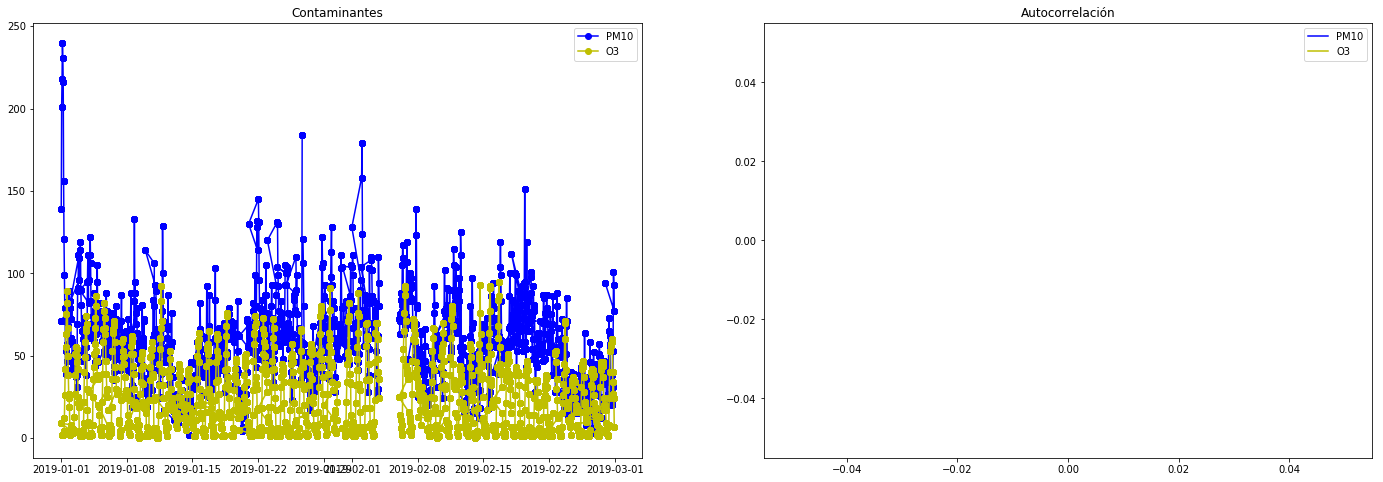

In [14]:
# Graficamos
fig, axes = plt.subplots(1, 2, figsize = (24,8))
autocorr_contaminante('PM10', 'b', axes = axes)
autocorr_contaminante('O3', 'y', axes = axes)

In [15]:
cont_ACO = estacion_ACO[["date","id_station","id_parameter","value"]]
cont_ACO = pd.pivot_table(cont_ACO,index=["date"],columns=["id_parameter"])

In [16]:
cont_ACO.columns = cont_ACO.columns.droplevel()

In [17]:
cont_ACO = cont_ACO.rename_axis([None] * 1)

In [18]:
cont_ACO.head()

id_parameter,CO,NO,NO2,NOX,O3,PM10,SO2
2019-01-01 00:00:00,0.4,11.0,22.0,33.0,9.0,71.0,3.0
2019-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,139.0,NaN
2019-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,201.0,NaN
2019-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,218.0,NaN
2019-01-01 04:00:00,1.5,25.0,22.0,47.0,2.0,240.0,2.0


In [19]:
cont_ACO.corr()

id_parameter,CO,NO,NO2,NOX,O3,PM10,SO2
id_parameter,,,,,,,
CO,1.000000,0.758716,0.698015,0.871509,-0.413394,0.407189,0.059490
NO,0.758716,1.000000,0.384303,0.915659,-0.474700,0.124729,0.003583
NO2,0.698015,0.384303,1.000000,0.722318,-0.509545,0.459375,-0.025732
NOX,0.871509,0.915659,0.722318,1.000000,-0.576540,0.293000,-0.008838
O3,-0.413394,-0.474700,-0.509545,-0.576540,1.000000,-0.112972,0.220913
PM10,0.407189,0.124729,0.459375,0.293000,-0.112972,1.000000,0.049146
SO2,0.059490,0.003583,-0.025732,-0.008838,0.220913,0.049146,1.000000


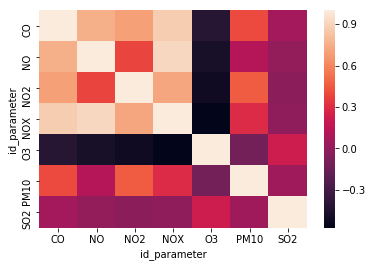

In [20]:
sns.heatmap(cont_ACO.corr())

In [21]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

In [22]:
NON_DER = ['date',]

In [23]:
df_new = df_derived_by_shift(cont_ACO, 1, NON_DER)

In [24]:
df_new.corr()

,CO,NO,NO2,NOX,O3,PM10,SO2,CO_1,NO_1,NO2_1,NOX_1,O3_1,PM10_1,SO2_1
CO,1.000000,0.758716,0.698015,0.871509,-0.413394,0.407189,0.059490,0.730508,0.600475,0.580606,0.700961,-0.406735,0.270274,-0.018604
NO,0.758716,1.000000,0.384303,0.915659,-0.474700,0.124729,0.003583,0.485178,0.668151,0.325436,0.640974,-0.494577,0.038892,-0.080134
NO2,0.698015,0.384303,1.000000,0.722318,-0.509545,0.459375,-0.025732,0.521589,0.260988,0.793838,0.543321,-0.419824,0.352565,-0.089731
NOX,0.871509,0.915659,0.722318,1.000000,-0.576540,0.293000,-0.008838,0.588923,0.612897,0.587232,0.714798,-0.551717,0.181855,-0.099491
O3,-0.413394,-0.474700,-0.509545,-0.576540,1.000000,-0.112972,0.220913,-0.307565,-0.348189,-0.484277,-0.471683,0.925220,-0.107506,0.272315
PM10,0.407189,0.124729,0.459375,0.293000,-0.112972,1.000000,0.049146,0.469934,0.191095,0.467354,0.346837,-0.080341,0.781824,0.022257
SO2,0.059490,0.003583,-0.025732,-0.008838,0.220913,0.049146,1.000000,0.107020,0.058268,-0.004332,0.041080,0.140236,0.060180,0.695693
CO_1,0.730508,0.485178,0.521589,0.588923,-0.307565,0.469934,0.107020,1.000000,0.758285,0.697056,0.871127,-0.412858,0.406768,0.060069
NO_1,0.600475,0.668151,0.260988,0.612897,-0.348189,0.191095,0.058268,0.758285,1.000000,0.382932,0.915596,-0.474284,0.124051,0.003945
NO2_1,0.580606,0.325436,0.793838,0.587232,-0.484277,0.467354,-0.004332,0.697056,0.382932,1.000000,0.721398,-0.509210,0.459077,-0.025230


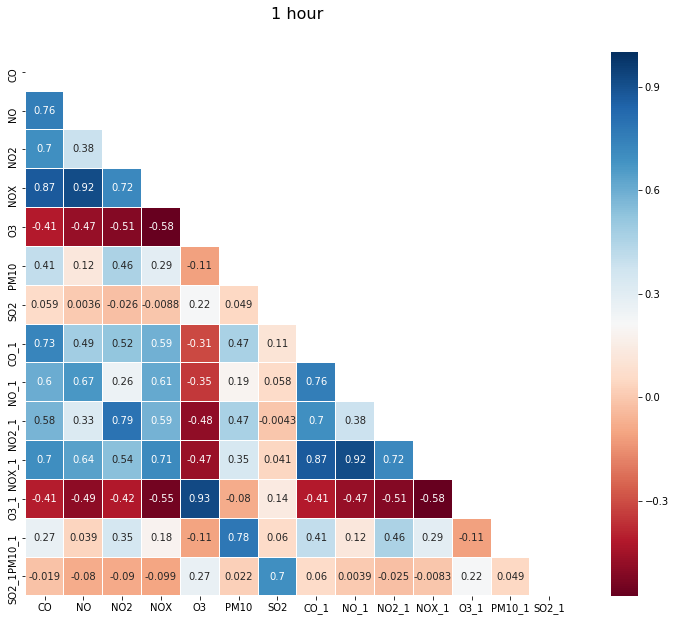

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'1 hour', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [26]:
df_new = df_derived_by_shift(cont_ACO, 2, NON_DER)

In [27]:
df_new.head()

,CO,NO,NO2,NOX,O3,PM10,SO2,CO_1,CO_2,NO_1,...,NO2_1,NO2_2,NOX_1,NOX_2,O3_1,O3_2,PM10_1,PM10_2,SO2_1,SO2_2
2019-01-01 00:00:00,0.4,11.0,22.0,33.0,9.0,71.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,139.0,NaN,0.4,NaN,11.0,...,22.0,NaN,33.0,NaN,9.0,NaN,71.0,NaN,3.0,NaN
2019-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,201.0,NaN,NaN,0.4,NaN,...,NaN,22.0,NaN,33.0,NaN,9.0,139.0,71.0,NaN,3.0
2019-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,218.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,201.0,139.0,NaN,NaN
2019-01-01 04:00:00,1.5,25.0,22.0,47.0,2.0,240.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,218.0,201.0,NaN,NaN


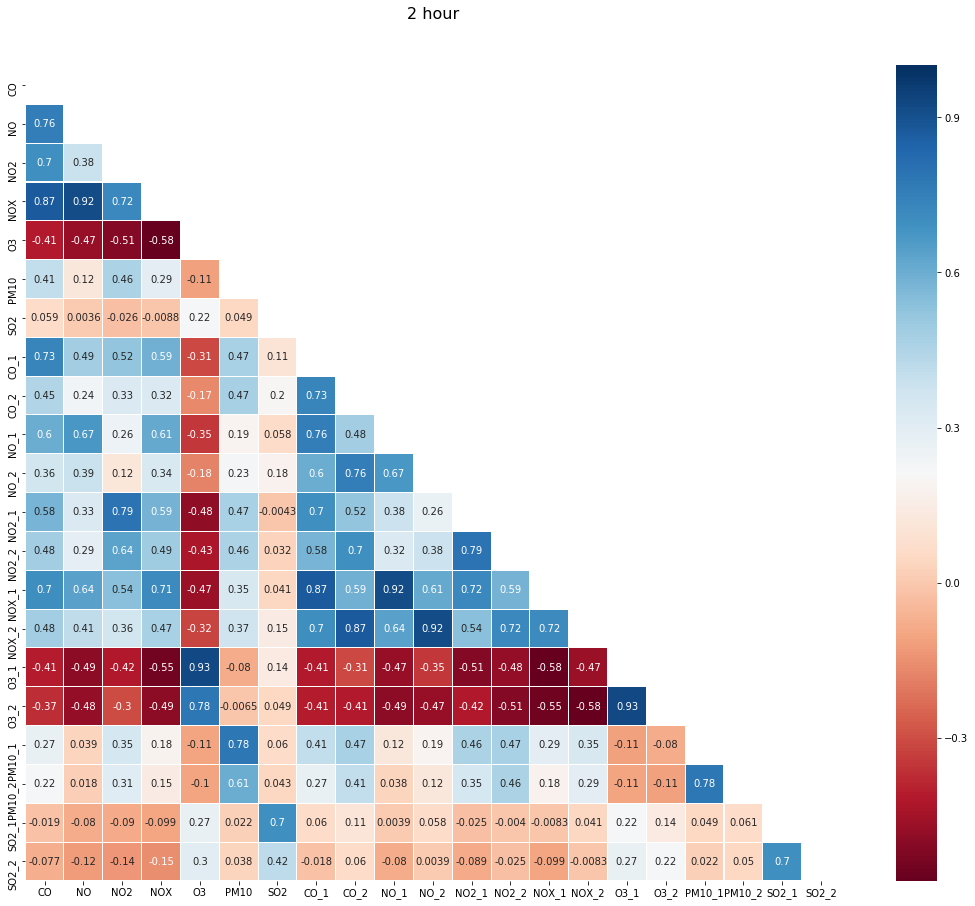

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(20,15))
plt.title(u'2 hour', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [29]:
cont_ACO_2 = estacion_ACO[["date","id_station","id_parameter","value"]]
cont_ACO_2 = pd.pivot_table(cont_ACO_2,index=["date"],columns=["id_parameter"])

In [30]:
cont_ACO_2.columns = cont_ACO_2.columns.droplevel()

In [31]:
cont_ACO_2= cont_ACO_2.rename_axis([None] * 1)

In [32]:
cont_ACO_2.head()

id_parameter,CO,NO,NO2,NOX,O3,PM10,SO2
2019-01-01 00:00:00,0.4,11.0,22.0,33.0,9.0,71.0,3.0
2019-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,139.0,NaN
2019-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,201.0,NaN
2019-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,218.0,NaN
2019-01-01 04:00:00,1.5,25.0,22.0,47.0,2.0,240.0,2.0


In [33]:
cont_ACO_2[(cont_ACO_2['id_parameter'] >= '2019-02-28 00:00:00')  ]

KeyError: 'id_parameter'